In [5]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE, MDS

import networkx as nx
import graphviz
import pydotplus
from networkx.drawing.nx_pydot import graphviz_layout

# Load data and replace outliers with the max value

In [6]:
df = pd.read_csv("data/bdata.csv")
df.loc[df.meas > 50000, "meas"] = 50000
df.loc[df.mhc == "HLAA1", "mhc"] = "HLAA0101"
df.loc[df.mhc == "HLAA11", "mhc"] = "HLAA0101"
df.loc[df.mhc == "HLAA2", "mhc"] = "HLAA0201"
df.loc[df.mhc == "HLAA3", "mhc"] = "HLAA0319"
df.loc[df.mhc == "HLAA3/11", "mhc"] = "HLAA0319"
df.loc[df.mhc == "HLAA26", "mhc"] = "HLAA2602"
df.loc[df.mhc == "HLAB7", "mhc"] = "HLAB0702"
df.loc[df.mhc == "HLACw1", "mhc"] = "HLAC0401"
df.loc[df.mhc == "HLACw4", "mhc"] = "HLAC0401"
df.loc[df.mhc == "HLAB8", "mhc"] = "HLAB0801"

# Load the ProtVec model

In [7]:
protvec_df = pd.read_table("data/protvec.csv", sep = "\\t", header=None)
protvec = {}
for ind, row in protvec_df.iterrows():
    row = list(row)
    row[0] = row[0][1:]
    row[-1] = row[-1][:-1]
    protvec[row[0]] = np.array(row[1:], dtype=float)

/Users/vdn/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


In [8]:
def pv_vec(seq, protvec=protvec):
    res = np.zeros((100, len(seq) - 2), dtype=float)
    for i in range(len(seq) - 2):
        res[:, i] = protvec[seq[i:i+3]]
    return res


def pv_sum(seq, protvec=protvec):
    res = np.zeros((100,), dtype=float)
    for i in range(len(seq) - 2):
        res += protvec[seq[i:i+3]]
    return res

# Load MHC sequences

In [9]:
mhc_df = pd.read_csv("data/mhc_seq_imghtla.csv")
mhc_df.mhc

0      HLAA0201
1      HLAA0211
2      HLAA2402
3      HLAA8001
4      HLAA3001
5      HLAA0202
6      HLAA0101
7      HLAA2301
8      HLAA2603
9      HLAA6801
10     HLAA3101
11     HLAA3201
12     HLAA2403
13     HLAA0207
14     HLAA3301
15     HLAA0319
16     HLAA0216
17     HLAA0217
18     HLAA0203
19     HLAA1101
20     HLAA2602
21     HLAA0210
22     HLAA6823
23     HLAA7401
24     HLAA2501
25     HLAA0219
26     HLAA0206
27     HLAA2902
28     HLAA1102
29     HLAA3215
         ...   
73     HLAB4013
74     HLAB4506
75     HLAB1402
76     HLAB1542
77     HLAB2720
78     HLAB1502
79     HLAB1801
80     HLAB3503
81     HLAB2706
82     HLAB1517
83     HLAB0702
84     HLAB4501
85     HLAB5703
86     HLAB3801
87     HLAB3508
88     HLAB2703
89     HLAB0801
90     HLAB4202
91     HLAB8101
92     HLAC0602
93     HLAC1502
94     HLAC0303
95     HLAC1402
96     HLAC0802
97     HLAC1203
98     HLAC0501
99     HLAC0702
100    HLAC0401
101    HLAE0103
102    HLAE0101
Name: mhc, dtype: object

# tSNE on MHC

In [ ]:
human_df = df.loc[df.species == "human", :]
human_df.shape

In [ ]:
human_peptide = np.zeros((human_df.shape[0], 100), dtype=np.float)
for i, pep in enumerate(human_df.sequence):
    human_peptide[i, :] = pv_sum(pep)

In [ ]:
# this is madness. MADNESS!!!
human_mhc = np.zeros((human_df.shape[0], 100), dtype=np.float)
for i, mhc_name in enumerate(human_df.mhc):
    try:
        human_mhc[i, :] = pv_sum(mhc_df.sequence[mhc_df.mhc == mhc_name].iloc[0])
    except Exception:
        print(human_df.iloc[i])

In [ ]:
human_data = np.hstack([human_peptide, human_mhc])
human_data.shape

In [ ]:
def compute_tsne(perp, data, classes):
    tsne = TSNE(perplexity=perp)
    vec_tsne = tsne.fit_transform(data)
    df_tsne = pd.DataFrame({"D1": vec_tsne[:,0], "D2": vec_tsne[:,1], "Class": classes})
    return sns.lmplot("D1", "D2", hue = "Class", data = df_tsne, fit_reg = False)


new_col = []
for i, mhc_name in enumerate(mhc_df.mhc):
    new_col.append(pv_sum(list(mhc_df.sequence[mhc_df.mhc == mhc_name])[0]))
    

classes = list(map(lambda x: x[3], mhc_df.mhc))
compute_tsne(15, new_col, classes)
compute_tsne(25, new_col, classes)
compute_tsne(30, new_col, classes)
compute_tsne(35, new_col, classes)

# MHC network

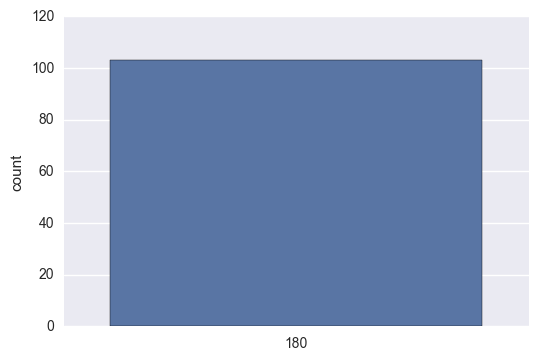

In [16]:
sns.countplot(list(map(len, mhc_df.sequence)))

In [15]:
mhc_df.sequence = list(map(lambda x: x[:180], mhc_df.sequence))

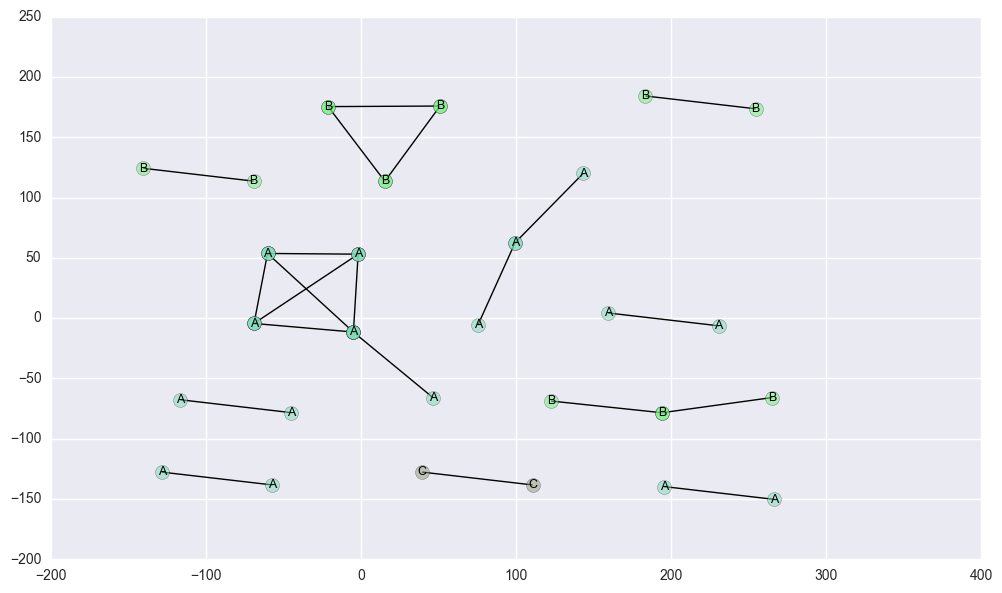

In [20]:
import random


def hamm_check(alpha, beta, max_dist):
    err = 0
    for a, b in zip(alpha, beta):
        err += a != b
        if err >= max_dist:
            return False
    return True
    

MAX_DIST = 3

G = nx.Graph()

mhc_classes = list(map(lambda x: x[3], mhc_df.mhc))

edges = []
labels = {}
color_classes = {x: random.random() for x in mhc_classes}
colors = {x: [] for x in color_classes}
nodes = {x: [] for x in color_classes}

for i in range(len(mhc_df) - 1):
    for j in range(i + 1, len(mhc_df)):
        if hamm_check(mhc_df.sequence.iloc[i], mhc_df.sequence.iloc[j], MAX_DIST):
            edges.append((i, j))
            labels[i] = mhc_classes[i]
            labels[j] = mhc_classes[j]
            colors[mhc_classes[i]].append(colors_classes[mhc_classes[i]])
            colors[mhc_classes[j]].append(colors_classes[mhc_classes[j]])
            nodes[mhc_classes[i]].append(i)
            nodes[mhc_classes[j]].append(j)
            G.add_edge(i, j)

plt.figure(1, figsize=(12, 7))
pos = graphviz_layout(G, prog="neato")
for ag in color_classes:
    nx.draw_networkx_nodes(G, 
                           pos,
                           nodes[ag],
                           node_color=[random.random(), random.random(), random.random()], 
                           node_size = 100, 
                           alpha = .5)
nx.draw_networkx_labels(G, 
                        pos, 
                        labels, 
                        font_size = 9)
nx.draw_networkx_edges(G, pos)